<a href="https://colab.research.google.com/github/PoonamMagadum/Parking-Classification/blob/master/3DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import argparse
import os
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten, MaxPooling3D, BatchNormalization)
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import regularizers
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import cv2
from easydict import EasyDict
%matplotlib inline

Using TensorFlow backend.


In [3]:
class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):
        print("test ",filename)
        cap = cv2.VideoCapture(filename)
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            frame = cv2.resize(frame, (self.height, self.width))
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        return np.array(framearray)

    def get_UCF_classname(self, filename):
        return filename[filename.find('_') + 1:filename.find('_', 2)]


In [4]:
def save_history(history, result_dir):
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    nb_epoch = len(acc)

    with open(os.path.join(result_dir, 'result.txt'), 'w') as fp:
        fp.write('epoch\tloss\tacc\tval_loss\tval_acc\n')
        for i in range(nb_epoch):
            fp.write('{}\t{}\t{}\t{}\t{}\n'.format(
                i, loss[i], acc[i], val_loss[i], val_acc[i]))

In [5]:

def loaddata(video_dir, vid3d, nclass, result_dir, color=False, skip=True):
    folders = os.listdir(video_dir)
    X = []
    labels = []
    labellist = []

    for folder in folders:
      files = os.listdir(video_dir+"/"+folder)
      pbar = tqdm(total=len(files))
      for filename in files:
          pbar.update(1)
          if filename == '.DS_Store':
              continue
          name = os.path.join(video_dir+"/"+folder, filename)
          # label = vid3d.get_UCF_classname(folder)
          label = folder
          if label not in labellist:
              if len(labellist) >= nclass:
                  continue
              labellist.append(label)
          labels.append(label)
          X.append(vid3d.video3d(name, color=color, skip=skip))

      pbar.close()
    with open(os.path.join(result_dir, 'classes.txt'), 'w') as fp:
        for i in range(len(labellist)):
            fp.write('{}\n'.format(labellist[i]))

    for num, label in enumerate(labellist):
        for i in range(len(labels)):
            if label == labels[i]:
                labels[i] = num
    if color:
        return np.array(X).transpose((0, 2, 3, 4, 1)), labels
    else:
        return np.array(X).transpose((0, 2, 3, 1)), labels


In [6]:
args = EasyDict({
    "batch": 32,
    "epoch": 500,
    "videos":'/content/drive/My Drive/dataset',
    "nclass":3,
    "color":True,
    "skip":False,
    "depth":12,
    "output": '/content/drive/My Drive/Parking Videos/result3' 
})

In [7]:
img_rows, img_cols, frames = 32, 32, args.depth
channel = 3 if args.color else 1
fname_npz = args.output+'/dataset_{}_{}_{}.npz'.format(
    args.nclass, args.depth, args.skip)


vid3d = Videoto3D(img_rows, img_cols, frames)
nb_classes = args.nclass
if os.path.exists(fname_npz):
    loadeddata = np.load(fname_npz)
    X, Y = loadeddata["X"], loadeddata["Y"]
else:
    x, y = loaddata(args.videos, vid3d, args.nclass,
                    args.output, args.color, args.skip)
    X = x.reshape((x.shape[0], img_rows, img_cols, frames, channel))
    Y = np_utils.to_categorical(y, nb_classes)

    X = X.astype('float32')
    np.savez(fname_npz, X=X, Y=Y)
    print('Saved dataset to dataset.npz.')
print('X_shape:{}\nY_shape:{}'.format(X.shape, Y.shape))

X_shape:(600, 32, 32, 12, 3)
Y_shape:(600, 3)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 32, 12, 32)    800       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 12, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 12, 32)    8224      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 12, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 16, 6, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 6, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 16, 16, 6, 64)    

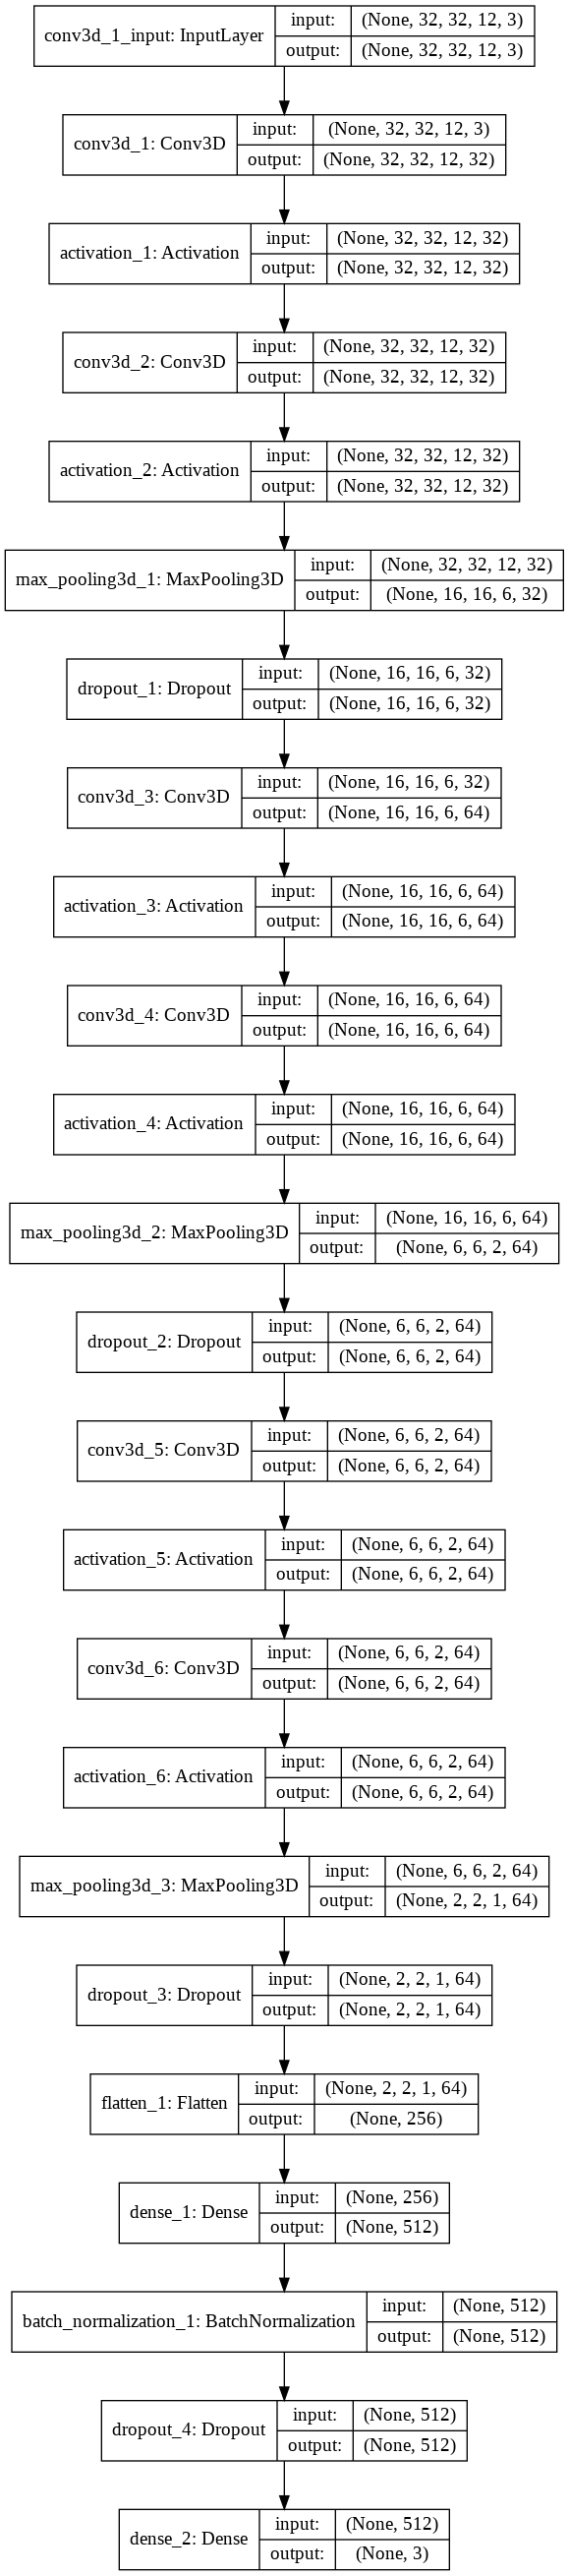

In [8]:
 # Define model
model = Sequential()
model.add(Conv3D(32, kernel_size=(2, 2, 2), input_shape=(X.shape[1:]), padding="same"))
model.add(Activation('relu'))
model.add(Conv3D(32, padding="same", kernel_size=(2, 2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding="same"))
model.add(Dropout(0.2))

model.add(Conv3D(64, padding="same", kernel_size=(2, 2, 2)))
model.add(Activation('relu'))
model.add(Conv3D(64, padding="same", kernel_size=(2, 2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.2))

model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(), metrics=['accuracy'])
model.summary()
plot_model(model, show_shapes=True,
            to_file=os.path.join(args.output, 'model.png'))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=43)

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=args.batch,
                    epochs=args.epoch, verbose=1, shuffle=True)

Train on 480 samples, validate on 120 samples
Epoch 1/500
480/480 [==============================] - 2s 5ms/step - loss: 1.2978 - accuracy: 0.3521 - val_loss: 12.5430 - val_accuracy: 0.3333
Epoch 2/500
480/480 [==============================] - 2s 4ms/step - loss: 1.2830 - accuracy: 0.3500 - val_loss: 4.7727 - val_accuracy: 0.3333
Epoch 3/500
480/480 [==============================] - 2s 4ms/step - loss: 1.1035 - accuracy: 0.4437 - val_loss: 1.2308 - val_accuracy: 0.4167
Epoch 4/500
480/480 [==============================] - 2s 4ms/step - loss: 1.0209 - accuracy: 0.4812 - val_loss: 1.5136 - val_accuracy: 0.2417
Epoch 5/500
480/480 [==============================] - 2s 4ms/step - loss: 0.9853 - accuracy: 0.4875 - val_loss: 1.1088 - val_accuracy: 0.4500
Epoch 6/500
480/480 [==============================] - 2s 4ms/step - loss: 0.9548 - accuracy: 0.5229 - val_loss: 1.7545 - val_accuracy: 0.2417
Epoch 7/500
480/480 [==============================] - 2s 4ms/step - loss: 0.9521 - accuracy: 0

In [ ]:
model.evaluate(X_test, Y_test, verbose=0)

[0.7302413046360016, 0.8166666626930237]

In [ ]:
model_json = model.to_json()
if not os.path.isdir(args.output):
    os.makedirs(args.output)
with open(os.path.join(args.output, '3dcnnmodel.json'), 'w') as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(args.output, '3dcnnmodel.hd5'))


In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.7302413046360016
Test accuracy: 0.8166666626930237


In [ ]:
save_history(history, args.output)

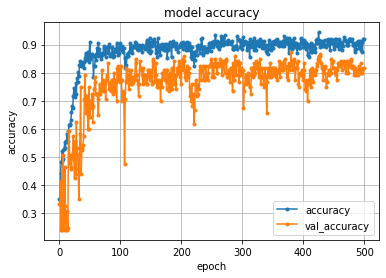

In [ ]:
plt.plot(history.history['accuracy'], marker='.')
plt.plot(history.history['val_accuracy'], marker='.')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.savefig(os.path.join(args.output, 'model_accuracy.png'))
plt.show()

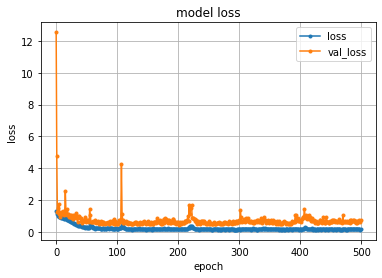

In [ ]:
plt.plot(history.history['loss'], marker='.')
plt.plot(history.history['val_loss'], marker='.')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.savefig(os.path.join(args.output, 'model_loss.png'))
plt.show()

In [ ]:
# Prepare data for prediction
img_rows, img_cols, frames = 32, 32, args.depth
channel = 3 if args.color else 1
vid3d = Videoto3D(img_rows, img_cols, frames)
video='/content/drive/My Drive/Parking Videos/Copy of Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)2.mp4'
test_data = vid3d.video3d(video, color=args.color, skip=args.skip)
t = np.expand_dims(test_data, axis=0)
print(t.shape)
td = np.array(t).transpose((0, 2, 3, 1, 4))
print(td.shape)
ls = [test_data]

test  /content/drive/My Drive/Parking Videos/Copy of Cars in Motion- The Rolling Shot Supercut - HALCYON (4K)2.mp4
(1, 12, 32, 32, 3)
(1, 32, 32, 12, 3)


In [ ]:
from keras.models import load_model
from keras.models import model_from_json
import json
with open(os.path.join(args.output, '3dcnnmodel.json'),'r') as f:
    print(type(f))
    for i in f:
      print(type(i))
      model_json = i
      break

model = model_from_json(model_json)
model.load_weights(os.path.join(args.output, '3dcnnmodel.hd5'))

<class '_io.TextIOWrapper'>
<class 'str'>


In [ ]:
# Predict.
predictions = model.predict(td)
print(predictions)

[[6.8128976e-04 1.7465475e-04 9.9914408e-01]]


In [ ]:
# Process predicted result
class_names = ['Parking','No_Parking','Car running']
class_names[np.argmax(predictions)]

'Car running'